Formato (shape) dos dados depois da divisão de janelas
Dominio do tempo: (24, 4, 125, 128) - (classes+ensaios, canais, janelas, linhas)
Dominio da frequência:  (24, 4, 125, 65) - (classes+ensaios, canais, janelas, linhas)
ACC SVM:  0.6266666666666667
29/29 [==============================] - 0s 881us/step
Acurácia: 45.00%
Matriz de confusão:
[[33  2  0 47  1 10 15  6]
 [ 5 47  1  0  5 18 23 20]
 [14  3 39 14  4 10  4 16]
 [25 23  0 45  1 16 13  0]
 [17  8  1  5 52  3 21 13]
 [ 3  0  5 24  1 64  9  6]
 [ 6 13  0  3 13 10 50 15]
 [ 0  2 11  0  2  2  6 75]]

              precision    recall  f1-score   support

           0    0.32039   0.28947   0.30415       114
           1    0.47959   0.39496   0.43318       119
           2    0.68421   0.37500   0.48447       104
           3    0.32609   0.36585   0.34483       123
           4    0.65823   0.43333   0.52261       120
           5    0.48120   0.57143   0.52245       112
           6    0.35461   0.45455   0.39841       110
      

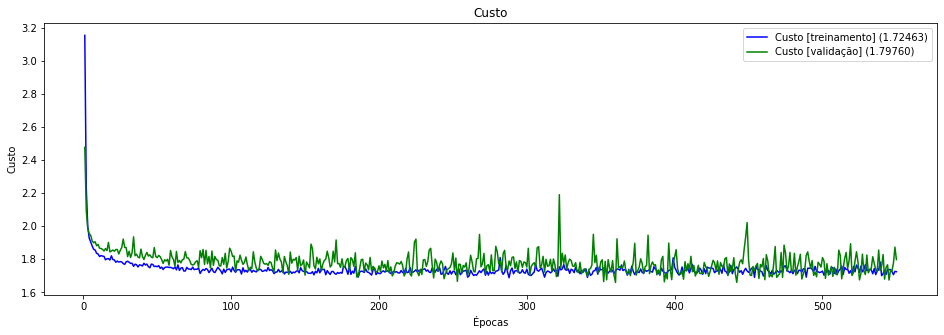

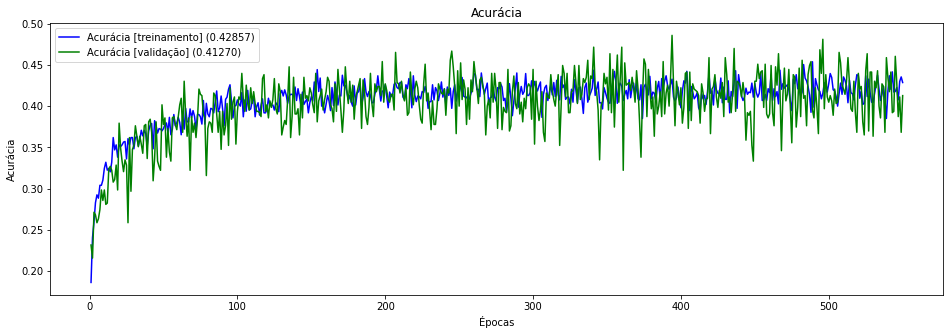

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from scipy import signal
from glob import glob
from scipy import stats
from scipy.signal import stft
from math import prod
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn import metrics

from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, Adam
from keras.utils.np_utils import to_categorical
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from urllib.request import urlopen, urlretrieve

import matplotlib.pyplot as plt
%matplotlib inline

rcParams['figure.figsize'] = [16., 5.]

#------ FILTROS DE BANDA

def butter_bandpass(data, lowcut, highcut, fs=200, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    return signal.filtfilt(b, a, data)

def butter_lowpass(data, lowcut, fs=200, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='lowpass')
    return signal.filtfilt(b, a, data)

def butter_highpass(data, highcut, fs=200, order=4):
    nyq = fs * 0.5
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='highpass')
    return signal.filtfilt(b, a, data)

def butter_notch(data, cutoff, var=1, fs=200, order=4):
    nyq = fs * 0.5
    low = (cutoff - var) / nyq
    high = (cutoff + var) / nyq
    b, a = signal.iirfilter(order, [low, high], btype='bandstop', ftype="butter")
    return signal.filtfilt(b, a, data)

def loadSujeito(dirs):
    data = np.load("datasets/topicos_cc/"+dirs)
    data = np.transpose(data, (0, 2, 1))
    data_filtered = butter_notch(data, 60)
    data_filtered = butter_highpass(data_filtered, 5)
    data_filtered = butter_lowpass(data_filtered, 50)
    
    return data_filtered

#------ Filtros 
def getZC(data, th):
    tamanho = len(data)
    somatoria = 0
    
    for i in range(tamanho-1):
        resultado = (data[i] * data[i+1] )
        resultado2 = np.abs(data[i] - data[i+1])
        if(resultado < 0 ) and (resultado2 > th):
            somatoria += 1
        
    return somatoria

def fj(i, sampleRate, tamanho):
    return i * sampleRate / (2 * tamanho)

def getFMN(data):
    tamanho = len(data)
    somatoria = 0
    sumPSD = np.sum(PSD(data))
    for i in range(tamanho):
        somatoria += (fj(i, 41, tamanho) * PSD(data[i]) ) / sumPSD
        
    return somatoria

def PSD(w):
    ''' definição da função PSD para o sinal no domínio da frequência '''
    return np.abs(w) ** 2

def wamp(x, th):
    res = np.abs(np.diff(x))
    return np.sum(res >= th, axis=-1)

def wl(x):
    res = np.abs(np.diff(x))
    return np.sum(res, axis=-1)

def var(x):
    return np.sum(x ** 2, axis=-1) / (np.prod(x.shape[:-1]) - 1)

def rms(x):
    return np.sqrt(np.sum(np.abs(x) ** 2, axis=-1) / (np.prod(x.shape[:-1])))

def fmd(w):
    return np.sum(PSD(w), axis=-1) / 2

def mmdf(w):
    return np.sum(np.abs(w), axis=-1) / 2

def zc(data,threshold):
    f =[]
    x,y,z = data.shape[:3]
    for xx in range(x):
        fx = []
        for yy in range(y):
            fy = []
            for zz in range(z):
                fy.append( getZC(data[xx][yy][zz], threshold ) )
            fx.append(fy)
        f.append(fx)
    return np.array(f)

def fmn(data):
    f =[]
    x,y,z = data.shape[:3]
    for xx in range(x):
        fx = []
        for yy in range(y):
            fy = []
            for zz in range(z):
                
                fy.append( getFMN(data[xx][yy][zz]) )
                
            fx.append(fy)
        f.append(fx)
    return np.array(f)

def A(w):
    return np.abs(w)

def getMMNF(data):
    tamanho = len(data)
    somatoria = 0
    
    sumA = np.sum(A(data))
    
    for i in range(tamanho):
        somatoria += (fj(i, 200, tamanho) * A(data[i]) ) / sumA 
        
    return somatoria

def mmnf(data):
    f =[]
    x,y,z = data.shape[:3]
    for xx in range(x):
        fx = []
        for yy in range(y):
            fy = []
            for zz in range(z):
                
                fy.append( getMMNF(data[xx][yy][zz]) )
                
            fx.append(fy)
        f.append(fx)
    return np.array(f)

def logD(data):
    from math import e
    N = np.prod(data.shape)
    
    return e ** ( np.sum(np.log10( np.abs(data) ), axis=-1) ) / N

def iemg(data):
    # tempo
    return np.sum(A(data), axis=-1)

def dasdv(data):
    #tempo
    return np.sqrt( np.sum(np.diff(data) ** 2, axis=-1) / (np.prod(data.shape[:-1]) - 1) )

def tmx(x, n):
    N = np.prod(x.shape[:-1])
    return np.abs(np.sum(x ** n, axis=-1) / N)

def do_svm(X,y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=True)

    clf = SVC(gamma='scale')
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    
    acc = metrics.accuracy_score(y_test, y_pred)
    
    return acc

def plot_history(h):
    loss_list = [s for s in h.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in h.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in h.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in h.history.keys() if 'acc' in s and 'val' in s]
    if len(loss_list) == 0:
        print('Custo não está presente no histórico')
        return
    epochs = range(1, len(history.history[loss_list[0]]) + 1)
    # Custo
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, h.history[l], 'b',
                 label='Custo [treinamento] (' + str(str(format(
                    h.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, h.history[l], 'g',
                 label='Custo [validação] (' + str(str(format(
                    h.history[l][-1],'.5f'))+')'))
    plt.title('Custo')
    plt.xlabel('Épocas')
    plt.ylabel('Custo')
    plt.legend()
    # Acurácia
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, h.history[l], 'b',
                 label='Acurácia [treinamento] (' + str(format(
                    h.history[l][-1],'.5f'))+')')
    for l in val_acc_list:
        plt.plot(epochs, h.history[l], 'g',
                 label='Acurácia [validação] (' + str(format(
                    h.history[l][-1],'.5f'))+')')
    plt.title('Acurácia')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.show()


dirs = [ i.split("/")[-1] for i in glob('datasets/topicos_cc/p1*')]
data = []
for d in dirs:
    data.append(loadSujeito(d))
    
X = np.concatenate((data), axis=0)


#---------------- Segmentação
data = X
step = 11.8
segment = 128

n_win = int((data.shape[-1] - segment) / step) + 1
ids = np.arange(n_win) * int(step)

# Janelas do dado no dominio do tempo
chunks_time = np.array([data[:,:,k:(k + segment)] for k in ids]).transpose(1, 2, 0, 3)

# Janelas do dado no domínio da frequência
_, _, chunks_freq = stft(data, fs=200, nperseg=128, noverlap=115)
chunks_freq = np.swapaxes(chunks_freq, 2, 3)

print('Formato (shape) dos dados depois da divisão de janelas')
print(f'Dominio do tempo: {chunks_time.shape} - (classes+ensaios, canais, janelas, linhas)')
print(f'Dominio da frequência:  {chunks_freq.shape} - (classes+ensaios, canais, janelas, linhas)')

th = np.median(chunks_time)

final_data = list()
final_data.append(var(chunks_time))
final_data.append(rms(chunks_time))
final_data.append(wamp(chunks_time, th))
final_data.append(logD(chunks_time))
final_data.append(wl(chunks_time))
final_data.append(zc(chunks_time,0))

final_data.append(iemg(chunks_time))
final_data.append(dasdv(chunks_time))
final_data.append(tmx(chunks_time, 3))
final_data.append(tmx(chunks_time, 4))
final_data.append(tmx(chunks_time, 5))

final_data.append(fmd(chunks_freq))
final_data.append(mmdf(chunks_freq))
final_data.append(fmn(chunks_freq))
final_data.append(mmnf(chunks_freq))

f, Pxx_den = signal.welch(data, fs=200, nperseg=248, noverlap=223)
final_data.append(Pxx_den)

final = np.array(final_data)

data = final.transpose(1, 3, 2, 0)
X = data.reshape(data.shape[0]*data.shape[1], data.shape[2]*data.shape[3])

y = [ [(i)] * int(X.shape[0] / 8 ) for i in range(8)]
y = np.array(y).flatten()

scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

#--------------- SVM

print("ACC SVM: ", do_svm(X_norm,y))


# Dividindo em conjuntos de treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X_norm, y, test_size=0.3)

# treino: 80% dos 80% de treino. Validacao: 20% dos 80% de treino.
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.3, shuffle=True)

# definição de uma fração do regularizador
l = 0.05

# desenvolvimento do modelo Keras para uma MLP
model = Sequential()
model.add(Dense(20, activation='relu', input_dim=64,
                kernel_regularizer=regularizers.l2(l)))
# Aplicação de um dropout (caso necessário)
model.add(Dropout(0.1))
model.add(Dense(10, activation='relu',
                kernel_regularizer=regularizers.l2(l)))
# Aplicação de um dropout (caso necessário)
model.add(Dropout(0.1))
model.add(Dense(8, activation='softmax'))

# Aplicação de um modelo de descida de gradiente utilizando o Stocastic Gradient Descendent (SGD)
sgd = SGD(learning_rate=0.07, momentum=0.1)
# Função de otimização da rede: ADAM
adam = Adam(learning_rate=0.003, beta_1=0.7, beta_2=0.500)
# Função de custo baseada em dados originalmente categóricos
model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd,
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=550, batch_size=15,
                    validation_data=(X_val, y_val), verbose=0)


predict_x=model.predict(X_test) 
score=np.argmax(predict_x,axis=1)
y_true = y_test

print('Acurácia: %0.2f%%' % (accuracy_score(y_true, score) * 100))
print('Matriz de confusão:')
print(confusion_matrix(y_true, score))
print()
print(classification_report(y_true, score, digits=5))

plot_history(history)

In [20]:
def rnn(l=0.01, learning_rate=0.07, dropout=0.1, batch_size=15, momentum):
    # definição de uma fração do regularizador

    # desenvolvimento do modelo Keras para uma MLP
    model = Sequential()
    model.add(Dense(20, activation='relu', input_dim=64,
                    kernel_regularizer=regularizers.l2(l)))
    # Aplicação de um dropout (caso necessário)
    model.add(Dropout(dropout))
    model.add(Dense(10, activation='relu',
                    kernel_regularizer=regularizers.l2(l)))
    # Aplicação de um dropout (caso necessário)
    model.add(Dropout(0.1))
    model.add(Dense(8, activation='softmax'))

    # Aplicação de um modelo de descida de gradiente utilizando o Stocastic Gradient Descendent (SGD)
    sgd = SGD(learning_rate=learning_rate, momentum=momentum)
    # Função de otimização da rede: ADAM
    adam = Adam(learning_rate=learning_rate, beta_1=0.7, beta_2=0.500)
    # Função de custo baseada em dados originalmente categóricos
    model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd,
                  metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=550, batch_size=batch_size,
                        validation_data=(X_val, y_val), verbose=0)


    predict_x=model.predict(X_test) 
    score=np.argmax(predict_x,axis=1)
    y_true = y_test

    print('Acurácia: %0.2f%%' % (accuracy_score(y_true, score) * 100))
    return accuracy_score(y_true, score) * 100

In [19]:
best_acc = 0
best_param = 0

# learning_rate=0.07, momentum=0.1, epochs=550, batch_size=15
for l in [0.1,0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    for learning_rate in [0.01,0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]:
        for momentum in [0.1,0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
            for dropout in [0.1,0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
                for batch_size in [10,15,20,25,30,35]:
                    acc = rnn(l, learning_rate, dropout, batch_size, momentum)
                    
                    if acc > best_acc:
                        best_acc = acc
                        best_param = ()
                    

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1
